In [2]:
import shapely
from shapely.geometry import LinearRing, LineString, Point
from numpy import sin, cos, pi, sqrt
from random import random

import numpy as np
from matplotlib import pyplot as plt

In [38]:
def placeParticles():
    random_values = np.random.rand(100,3)
    
    calc_pos_x = np.vectorize(lambda x: start_x + range_x * x)
    calc_pos_y = np.vectorize(lambda y: start_y - range_y * y)
    calc_q = np.vectorize(lambda q: 2 * np.pi * q)
    
    x_vect = calc_pos_x(random_values[:,:1])
    y_vect = calc_pos_y(random_values[:,1:2])
    q_vect = calc_q(random_values[:,2:3])

    particles = np.concatenate((x_vect, y_vect, q_vect), axis=1)
    return particles

In [35]:
print(random_values[:,1:2])
# result = np.apply_along_axis(calc_pos_x, 0, random_values[:,:1])
# random_values[:,:1]


array([[ 2.82478371e-01, -2.05950447e-01,  5.15923549e+00],
       [-2.86579905e-01,  5.91231298e-01,  2.11550006e+00],
       [-1.27516485e-01,  4.32905274e-01,  9.18250123e-01],
       [ 1.06038871e-01,  4.72019441e-01,  4.31356515e+00],
       [-3.78723739e-01,  1.60336399e-01,  4.78259229e+00],
       [ 2.61660032e-01, -6.75233895e-01,  5.85850644e+00],
       [-7.69315354e-02,  2.72711649e-02,  9.39367247e-01],
       [-2.46118540e-01,  8.75245880e-02,  1.18377016e+00],
       [-7.90529598e-02, -1.84452530e-01,  6.07164906e+00],
       [-2.29868622e-01,  2.01751332e-01,  2.36981481e+00],
       [-1.61845209e-01, -6.44244095e-01,  6.65385906e-01],
       [ 3.43438679e-02,  9.84735721e-02,  1.83471566e+00],
       [-2.51469643e-02,  3.71982631e-01,  1.73940437e+00],
       [-2.81676016e-03, -2.35138886e-01,  4.68944816e-01],
       [ 1.21974834e-01, -7.33114053e-01,  1.90143080e+00],
       [-1.55583963e-01,  2.67261643e-01,  1.43967279e+00],
       [ 1.08727150e-01, -6.62288265e-01

In [81]:
# A prototype simulation of a differential-drive robot with one sensor

# Constants

R = 0.021  # radius of wheels in meters
L = 0.094  # distance between wheels in meters

W = 1.18  # width of arena
H = 1.94  # height of arena
margin = 0.2 # waiting area in arena

start_x = -0.59 + margin
start_y = 0.97 - margin

range_x = W - 2 * margin
range_y = H - 2 * margin

robot_timestep = 0.1        # 1/robot_timestep equals update frequency of robot
simulation_timestep = 0.01  # timestep in kinematics sim (probably don't touch..)

# the world is a rectangular arena with width W and height H
world = LinearRing([(W/2,H/2),(-W/2,H/2),(-W/2,-H/2),(W/2,-H/2)]) 

# Variables 
###########

x = 0   # robot position in meters - x direction - positive to the right 
y = 0   # robot position in meters - y direction - positive up
q = 0.0   # robot heading with respect to x-axis in radians 

left_wheel_velocity =  random()   # robot left wheel velocity in radians/s
right_wheel_velocity =  random()  # robot right wheel velocity in radians/s

# Sensor measurements
##################

# central sensor: robot starts 80mm in front 0.008
# side sensors: robot starts 78mm in front 0.0078

# Kinematic model
#################
# updates robot position and heading based on velocity of wheels and the elapsed time
# the equations are a forward kinematic model of a two-wheeled robot - don't worry just use it
def simulationstep():
    global x, y, q
    
    particles = []

    for step in range(int(robot_timestep/simulation_timestep)):     #step model time/timestep times
        v_x = cos(q)*(R*left_wheel_velocity/2 + R*right_wheel_velocity/2) 
        v_y = sin(q)*(R*left_wheel_velocity/2 + R*right_wheel_velocity/2)
        omega = (R*right_wheel_velocity - R*left_wheel_velocity)/(2*L)    
    
        x += v_x * simulation_timestep
        y += v_y * simulation_timestep
        q += omega * simulation_timestep

# Simulation loop
#################
file = open("trajectory.dat", "w")


def detectCorner(camrays):
    left = -0.59
    right = 0.59
    top = 0.97
    bot = -0.97
    
    detected = []
    for i, ray in enumerate(camrays):
        s = world.intersection(ray)
        # top right corner
        if s.x == right and s.y == top:
            detected.append(2)
        # bot right corner
        elif s.x == right and s.y == bot:
            detected.append(4)
        # bot left corner
        elif s.x == left and s.y == bot:
            detected.append(6)
        # top left corner
        elif s.x == left and s.y == top:
            detected.append(8)      
        # top wall
        elif s.y == top:
            detected.append(1)
        # right wall
        elif s.x == right:
            detected.append(3)
        # bot wall
        elif s.y == bot:
            detected.append(5)
        # left wall
        elif s.x == left:
            detected.append(7)
    
    """
    Coordinates:
    Going clockwise starting with top wall == case 1
    We have 8 cases of hitting one of the walls(4) or one of the corners directly(4).
    """
    
    detect = (detected[0], detected[1])
    
    if detect == (1,1) or detect == (3,3) or detect == (5,5) or detect == (7,7):
        return None
    if detect == (1,2) or detect == (1,3) or detect == (2,3):
        return "red top right"
    if detect == (3,4) or detect == (3,5) or detect == (4,5):
        return "green bot right"
    if detect == (5,6) or detect == (5,7) or detect == (6,7):
        return "blue bot left"
    if detect == (7,8) or detect == (7,1) or detect == (8,1):
        return "yellow top left"
    if detect == (3,7):
        return "Green and Blue - bot"
    if detect == (7,3):
        return "Red and Yellow - top"
    if detect == (1,5):
        return "Red and Green - right"
    if detect == (5,1):
        return "Blue and Yellow - left"
    return "error"
    
cornerArr = []

# converts degrees to radians
def dtr(degree):
    return degree * (np.pi / 180)
    

for cnt in range(10000):
    # "simple" eight-ray sensor
    ray_0 = LineString([(x, y), (x+cos(q)*2*W,(y+sin(q)*2*H))]) # q = radians of robot
    ray_45 = LineString([(x, y), (x+cos(q+dtr(45))*2*W,(y+sin(q+dtr(45))*2*H))])
    ray_90 = LineString([(x, y), (x+cos(q+dtr(90))*2*W,(y+sin(q+dtr(90))*2*H))])
    ray_135 = LineString([(x, y), (x+cos(q+dtr(135))*2*W,(y+sin(q+dtr(135))*2*H))])
    ray_180 = LineString([(x, y), (x+cos(q+dtr(180))*2*W,(y+sin(q+dtr(180))*2*H))])
    ray_225 = LineString([(x, y), (x+cos(q+dtr(225))*2*W,(y+sin(q+dtr(225))*2*H))])
    ray_270 = LineString([(x, y), (x+cos(q+dtr(270))*2*W,(y+sin(q+dtr(270))*2*H))])
    ray_315 = LineString([(x, y), (x+cos(q+dtr(315))*2*W,(y+sin(q+dtr(315))*2*H))])

    ray_Camera_L = LineString([(x, y), (x+cos(q-dtr(62.2))*2*W,(y+sin(q-dtr(62.2))*2*H)) ])  # a line from robot to a point outside arena in direction of q
    ray_Camera_R = LineString([(x, y), (x+cos(q+dtr(62.2))*2*W,(y+sin(q+dtr(62.2))*2*H)) ])  # a line from robot to a point outside arena in direction of q
    
    camray = [ray_Camera_R, ray_Camera_L]
    rays = [ray_0, ray_45, ray_90, ray_135, ray_180, ray_225, ray_270, ray_315]
    
    cornerArr.append(detectCorner(camray))
    
    min_distance = 100 # dummy large number
    for i,ray in enumerate(rays):
        s = world.intersection(ray)
        distance = sqrt((s.x-x)**2+(s.y-y)**2)
        if distance < min_distance:
            min_distance = distance
            direction = i # if direction is 0, obstacle sensed Left. If 1, obstacle straight ahead. If 2, obstacle to the right.
            # distance to wall
    
    obstacle = 0
    # simple controller - change direction of wheels every 10 seconds (100*robot_timestep) unless close to wall then turn on spot
    if (distance < 0.20): # OBSTACLE SENSED. #TODO: input sensor distance from robot centre (80 mm)
        obstacle = 1
        if direction == 0: # Obstacle to left. turn right
            left_wheel_velocity = -0.4
            right_wheel_velocity = 0.4
            
        if direction == 1: # obstacle ahead. turn right
            left_wheel_velocity = 0.4 # Original code. If delete, keep this
            right_wheel_velocity = -0.4
            
        if direction == 2: #obstacle to the right. turn left
            left_wheel_velocity = 0.4 
            right_wheel_velocity = -0.4

    else:
        obstacle = 0
        if cnt%100==0:
            speed = random()
        
            left_wheel_velocity = speed
            right_wheel_velocity = speed
        
    #step simulation
    simulationstep()

    #check collision with arena walls 
    if (world.distance(Point(x,y))<L/2):
        break
        
    if cnt%50==0:
        # ATTN: CHANGE LAST TWO VALUES IF WE MOVE UP TO FIVE SENSORS. CODE WILL NOT WORK
        file.write( str(x) + ", " + str(y) + ", " + str(cos(q)*0.05) + ", " + str(sin(q)*0.05) + ", " + str(obstacle) + ", " + str(cos(q+((direction-1)*np.pi/4))*0.05) + ", " + str(sin(q+((direction-1)*np.pi/4))*0.05) + "\n")

file.close()

In [82]:
# load data from file into numpy
data = np.loadtxt('trajectory.dat', delimiter=", ")
print(data)

[[ 4.85034450e-05  0.00000000e+00  5.00000000e-02 ...  0.00000000e+00
   5.00000000e-02  0.00000000e+00]
 [ 2.47367569e-03  0.00000000e+00  5.00000000e-02 ...  0.00000000e+00
   5.00000000e-02  0.00000000e+00]
 [ 6.58220465e-03  0.00000000e+00  5.00000000e-02 ...  0.00000000e+00
   5.00000000e-02  0.00000000e+00]
 ...
 [ 4.09041275e-01  2.53382542e-01 -5.34419076e-03 ...  0.00000000e+00
   3.13738931e-02 -3.89317201e-02]
 [ 4.07864770e-01  2.42438276e-01 -5.34419076e-03 ...  0.00000000e+00
   3.13738931e-02 -3.89317201e-02]
 [ 3.97476856e-01  1.45806179e-01 -5.34419076e-03 ...  0.00000000e+00
   3.13738931e-02 -3.89317201e-02]]


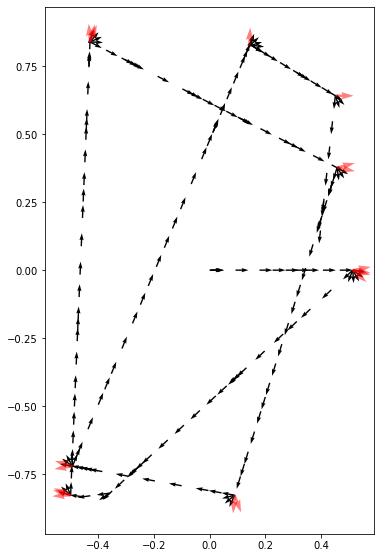

In [83]:
f, ax = plt.subplots(1,1, figsize=(W*5,H*5))
ax.set_xlim(-W/2, W/2)
ax.set_ylim(-H/2, H/2)

ax.quiver(data[:,0], data[:,1], data[:,2], data[:,3])

# When the robot senses an obstacle, draw the sensor that detects it.
obstacled = data[data[:,4] == 1]
ax.quiver(obstacled[:,0], obstacled[:,1], obstacled[:,5], obstacled[:,6], color='red',alpha=0.5)


plt.show()

In [84]:
print(cornerArr)

['Red and Green - right', 'Red and Green - right', 'Red and Green - right', 'Red and Green - right', 'Red and Green - right', 'Red and Green - right', 'Red and Green - right', 'Red and Green - right', 'Red and Green - right', 'Red and Green - right', 'Red and Green - right', 'Red and Green - right', 'Red and Green - right', 'Red and Green - right', 'Red and Green - right', 'Red and Green - right', 'Red and Green - right', 'Red and Green - right', 'Red and Green - right', 'Red and Green - right', 'Red and Green - right', 'Red and Green - right', 'Red and Green - right', 'Red and Green - right', 'Red and Green - right', 'Red and Green - right', 'Red and Green - right', 'Red and Green - right', 'Red and Green - right', 'Red and Green - right', 'Red and Green - right', 'Red and Green - right', 'Red and Green - right', 'Red and Green - right', 'Red and Green - right', 'Red and Green - right', 'Red and Green - right', 'Red and Green - right', 'Red and Green - right', 'Red and Green - right',